# MNIST VAE

In [1]:
from projectlib.imports import *
from projectlib.datasets import mnist
from projectlib.vae import VAE, Sampling
from projectlib.viz import view_images, plot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
%matplotlib inline

## MNIST

In [2]:
X, y = mnist.load_data(frac=0.25)
input_shape = X[0].shape

y_ohe = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, train_size=0.8, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)

(14000, 28, 28, 1)
(14000, 10)


In [3]:
latent_dim = 64

In [4]:
def get_encoder(input_shape, latent_dim):
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(encoder_inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=(1, 1), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=(7, 7), padding='same')(x)
    x = Reshape((128,))(x)
    x = BatchNormalization()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z])
    encoder._input_shape = input_shape
    encoder._latent_dim = latent_dim
    return encoder

encoder = get_encoder(input_shape, latent_dim)
#plot_model(encoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [5]:
def get_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim, ))
    x = Dense(128)(latent_inputs)
    x = Reshape((1,1,128,))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=(7, 7), padding='same')(x)
    x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', strides=(1, 1), padding='same')(x)
    
    decoder = Model(latent_inputs, decoded)
    decoder._latent_dim = latent_dim
    return decoder

decoder = get_decoder(latent_dim)
#plot_model(decoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [6]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

In [7]:
training_config = Munch(
    batch_size=32,
    num_epochs=20,
    verbose=2,
)
history = vae.fit(X_train, X_test, **training_config)

......Epoch 0: {'loss': 42.594566, 'reconstruction_loss': 41.779667, 'kl_loss': 0.81490004}
......Epoch 1: {'loss': 29.207478, 'reconstruction_loss': 27.950365, 'kl_loss': 1.2571133}
......Epoch 2: {'loss': 23.577614, 'reconstruction_loss': 22.286446, 'kl_loss': 1.2911682}
......Epoch 3: {'loss': 20.905472, 'reconstruction_loss': 19.499228, 'kl_loss': 1.4062439}
......Epoch 4: {'loss': 18.993704, 'reconstruction_loss': 17.584322, 'kl_loss': 1.4093827}
......Epoch 5: {'loss': 17.891352, 'reconstruction_loss': 16.482409, 'kl_loss': 1.4089437}
......Epoch 6: {'loss': 16.843876, 'reconstruction_loss': 15.463533, 'kl_loss': 1.3803424}
......Epoch 7: {'loss': 16.278948, 'reconstruction_loss': 14.953033, 'kl_loss': 1.3259141}
......Epoch 8: {'loss': 15.721879, 'reconstruction_loss': 14.389057, 'kl_loss': 1.332822}
......Epoch 9: {'loss': 15.5749, 'reconstruction_loss': 14.243159, 'kl_loss': 1.3317405}
......Epoch 10: {'loss': 15.036804, 'reconstruction_loss': 13.709907, 'kl_loss': 1.3268975}


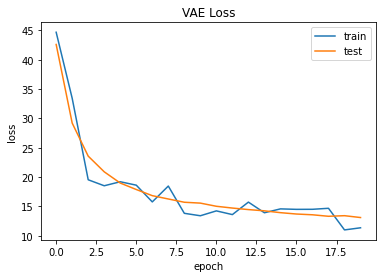

In [8]:
plot(labels=['train', 'test'],
     plots=(history['loss'], history['val_loss']),
     title='VAE Loss',
     xlabel='epoch',
     ylabel='loss')

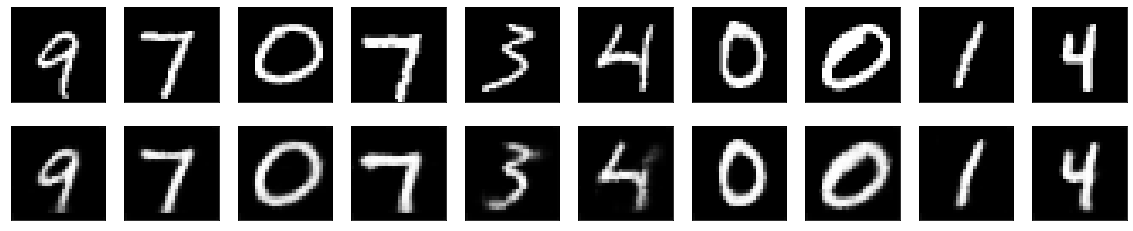

In [9]:
view_images(X_test[:10], decoder, encoder)

In [10]:
def get_classifier(encoder, n_classes):
    encoder_inputs = Input(shape=encoder._input_shape)
    _, _, encoded = encoder(encoder_inputs)
    x = Dense(32, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
    classifier = Model(encoder_inputs, output)
    classifier._input_shape = encoder._input_shape
    classifier._latent_dim = encoder._latent_dim
    classifier._n_classes = n_classes
    return classifier

classifier = get_classifier(encoder, mnist.n_classes)
#plot_model(classifier, show_shapes=True, show_layer_names=False, expand_nested=True)

In [11]:
classifier.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)
history = classifier.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
438/438 [==============================] - 7s 16ms/step - loss: 0.4415 - categorical_accuracy: 0.8675 - val_loss: 0.2457 - val_categorical_accuracy: 0.9300
Epoch 2/10
438/438 [==============================] - 6s 13ms/step - loss: 0.1547 - categorical_accuracy: 0.9541 - val_loss: 1.7962 - val_categorical_accuracy: 0.8429
Epoch 3/10
438/438 [==============================] - 6s 14ms/step - loss: 0.1151 - categorical_accuracy: 0.9641 - val_loss: 0.1549 - val_categorical_accuracy: 0.9569
Epoch 4/10
438/438 [==============================] - 6s 14ms/step - loss: 0.0923 - categorical_accuracy: 0.9720 - val_loss: 0.1617 - val_categorical_accuracy: 0.9537
Epoch 5/10
438/438 [==============================] - 6s 14ms/step - loss: 0.0807 - categorical_accuracy: 0.9751 - val_loss: 0.2025 - val_categorical_accuracy: 0.9434
Epoch 6/10
438/438 [==============================] - 6s 13ms/step - loss: 0.0641 - categorical_accuracy: 0.9808 - val_loss: 0.1656 - val_categorical_accuracy: 0.949

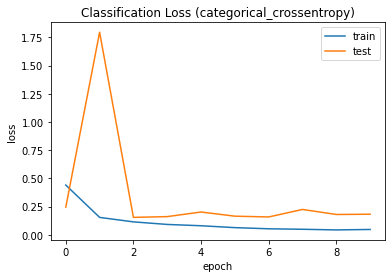

In [12]:
plot(labels=['train', 'test'],
     plots=(history.history['loss'], history.history['val_loss']),
     title='Classification Loss (categorical_crossentropy)',
     xlabel='epoch',
     ylabel='loss')

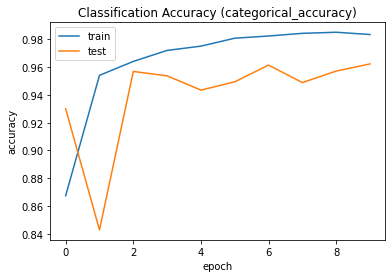

In [13]:
plot(labels=['train', 'test'],
     plots=(history.history['categorical_accuracy'],
            history.history['val_categorical_accuracy']),
     title='Classification Accuracy (categorical_accuracy)',
     xlabel='epoch',
     ylabel='accuracy')